In [13]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from io import StringIO

# Traineeship : Numerical Fluid Dynamics
## Potential-Flow Theory : 2D Flow Aroud a Symetrical Airfoil 

##### Ilan Renous

In this paper, we are going to compute the flow around a symetrical Airfoil according to the potential-flow theory. To this end, we will use the linearity of this theory, to add elementary flow solutions that imitate a symmetrical wing.


### Linearity

In the potential flow theory, the flow is irrotational. this means that

$$\omega=\nabla\times\mathbf{v}=0$$

It follows from there that there exist a fiel $\phi$ such as 

$$\mathbf{v}=\nabla \phi$$

For an incompressible flow, respecting the condition $\nabla\cdot\mathbf{v}=0$, we get governing equation of potential flow:

$$\nabla^2\phi=0$$

So any solution to a Laplace equation can be a potential flow. This equation is linear. That means that the sum of any solution is still a solution.


### Source and Sink

Sources and sinks are elementary solutions to the governing equation of the potential flow that can be added to model the flow of different situatins

A source is a point from which we imagine that fluid is flowing out, uniformly.  In cylindrical coordinate system, the velocity components of a source flow are :

$$u_r\left(r,\theta\right) = \frac{\sigma}{2\pi r} \text{,} \qquad u_\theta\left(r,\theta\right)=0$$

where $\sigma$ represents the source *strength*. If $\sigma<0$ it is called a sink.

The stream function $\psi$  in cylindrical coordinates $\psi$ is obtained from:

$$\frac{1}{r}\frac{\partial\psi}{\partial\theta} = u_r \quad \text{,} \quad -\frac{\partial\psi}{\partial r} = u_\theta$$

which integrates to

$$\psi = \frac{\sigma}{2\pi}\theta + \text{constant}$$

We are more interested in the velocity components that are obtained by differentiation of the stream function, so that the constant can be dropped.

In Cartesian coordinates, the velocity field $\left(u,v\right)$ at position $\left(x,y\right)$ corresponding to a source of strength $\sigma$ located at $\left(x_\text{source},y_\text{source}\right)$ is given by:

$$u = \frac{\partial\psi}{\partial y} = \frac{\sigma}{2\pi}\frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

and

$$v = -\frac{\partial\psi}{\partial x} = \frac{\sigma}{2\pi}\frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

We can implement a function that gives the speed of the flow generated by a source and it's stream function.

In [14]:
def get_velocity(sigma, xs, ys, X, Y):
    """Returns the velocity field generated by a source/sink.
    
    Arguments
    ---------
    strength -- strength of the source/sink.
    xs, ys -- coordinates of the source/sink.
    X, Y -- mesh grid.
    """
    u = sigma/(2*numpy.pi)*(X-xs)/((X-xs)**2+(Y-ys)**2)
    v = sigma/(2*numpy.pi)*(Y-ys)/((X-xs)**2+(Y-ys)**2)
    
    return u, v

In [15]:
def get_stream_function(sigma, xs, ys, X, Y):
    """Returns the stream-function generated by a source/sink.
    
    Arguments
    ---------
    strength -- strength of the source/sink.
    xs, ys -- coordinates of the source/sink.
    X, Y -- mesh grid.
    """
    psi = sigma/(2*numpy.pi)*numpy.arctan2((Y-ys), (X-xs))
    
    return psi

### Source Distribution on an Airfoil

For non-lifting bodies, we can use a source distribution on the body surface, superposed with a free stream. This set of sources is choses so that the tangential speed of the flow is zero on the surface of this body. In this paper, we will build the flow around a NACA0012 airfoil, using a set of sources. The sources position and stength has been computed for us and we will load the document with those information.

In [16]:
#Load the position and the strength of the sources
x_source =numpy.loadtxt('NACA0012_x.txt')
y_source =numpy.loadtxt('NACA0012_y.txt')
sigma_source =numpy.loadtxt('NACA0012_sigma.txt')
numpy.shape(x_source)

(100,)

We will use a 51 mesh points in each direction, and a domain $[-1, 2]\times[-0.5, 0.5]$.

In [17]:
N = 51                                # Number of points in each direction
x_start, x_end = -1.0, 2.0            # x-direction boundaries
y_start, y_end = -0.5, 0.5            # y-direction boundaries
x = numpy.linspace(x_start, x_end, N)    # creates a 1D-array for x
y = numpy.linspace(y_start, y_end, N)    # creates a 1D-array for y
X, Y = numpy.meshgrid(x, y)              # generates a mesh grid

Using the linearity of the equations for $\phi$, we can compute the contribution of each source by simply adding them one to another.

In [18]:
#speed and stream function of the sources
u_source =numpy.zeros((N,N))
v_source =numpy.zeros((N,N))
psi_source=numpy.zeros((N,N))

#contribution of each source
u_all_sources=numpy.zeros((N,N))
v_all_sources=numpy.zeros((N,N))
psi_all_sources=numpy.zeros((N,N))

for i in range (0,100):# compute the sum of all the sources
    u_source, v_source= get_velocity(sigma_source[i], x_source[i], y_source[i], X, Y)
    psi_source= get_stream_function(sigma_source[i], x_source[i], y_source[i], X, Y)
    
    u_all_sources=u_all_sources+u_source
    v_all_sources=v_all_sources+v_source
    psi_all_sources=psi_all_sources+psi_source
    

We will add a uniform flow to the total flow.
The streamlines of a freestream with speed $U_\infty$ and angle of attack $\alpha$ are given by:

$$\psi_\text{freestream}\left(x,y\right) = U_\infty \left(y\cos\alpha - x\sin\alpha\right)$$

 If the flow is completely horizontal, $\psi= U_\infty y$. Thus  $u=U_\infty$ and $v=0$.

In [19]:
#horizontal uniform flow 
u_inf = 1.0
u_freestream = u_inf* numpy.ones((N, N), dtype=float)
v_freestream = 0


We finnaly add all the contributions.

In [25]:
#add all the contributions
u_tot=u_all_sources+u_freestream 
v_tot=v_all_sources+v_freestream
psi_tot=psi_all_sources+v_freestream

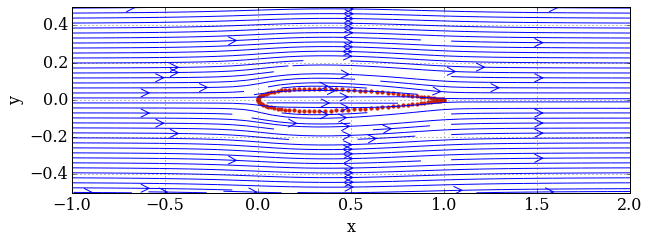

In [26]:
#plot of the flow
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

#plot the sources on the surface of the airfoil
pyplot.scatter(x_source ,y_source, color='#CD2305', s=10, marker='o')

#plot the stream
pyplot.streamplot(X, Y, u_tot, v_tot, density=1.3, linewidth=1, arrowsize=2, arrowstyle='->')


It does look like a wing! 

### Bernoulli's equation and the pressure coefficient

To evaluate the pressure coefficient $C_p$, we apply Bernoulli's equation for an imcompressible flow:

$$p_\infty + \frac{1}{2}\rho V_\infty^2 = p + \frac{1}{2}\rho V^2$$

valid along a streamline

We define the pressure coefficient in the following way:

$$C_p = \frac{p-p_\infty}{\frac{1}{2}\rho V_\infty^2}$$

i.e.,

$$C_p = 1 - \left(\frac{V}{V_\infty}\right)^2$$

Note that in an incompressible flow, $C_p=1$ at a stagnation point.

We are now going to plot the pressure coefficient throughout the flow field.

In [22]:
# computes the pressure coefficient field
cp = 1.0 - (u_tot**2+v_tot**2)/u_inf**2

#find the maximum pressure point
pmax1=numpy.argmax(cp)
yi,xi=numpy.unravel_index(pmax1,cp.shape)

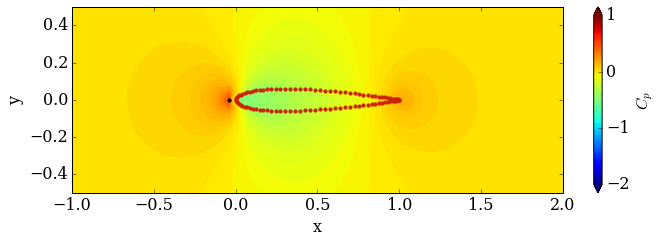

In [23]:
# plots the pressure coefficient field
size = 10
pyplot.figure(figsize=(1.1*size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
contf = pyplot.contourf(X, Y, cp, levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-2.0, -1.0, 0.0, 1.0])
pyplot.scatter(x_source ,y_source, color='#CD2305', s=10, marker='o')
pyplot.scatter(x[xi] ,y[yi], color='k', s=10, marker='o')

The point where the pressure is maximum is illustrated in black. It is naturally at the front end of the wing.

### Conclusion

The use of source distribution on a body surface is really easy to implement, but cannot be applied to a more general situation. Like we said, this method would not work for a lifting body for example. This method is in fact a consequence of a zero perpendicular speed on a body surface. The strength of the sources are indeed chosen to match this condition. A much more general approach is to directly implement a zero perpendicular speed on the body surface. This can be done, but requires the use of more advanced python features.


##### Source

(1) We used the following lectures https://github.com/barbagroup/AeroPython/tree/master/lessons available under Creative Commons Attribution license, CC-BY. Code under MIT license. (c)2014 Lorena A. Barba, Pi-Yueh Chuang. Thanks: NSF for support via CAREER award #1149784.under Creative Commons Attribution license CC-BY 4.0, (c)2014 L.A. Barba, C. Cooper, G.F. Forsyth, A. Krishnan.

In [24]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())